<h1><center>Machine Learning Group Project</center></h1>

In [160]:
import pandas as pd
import numpy as np
import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import randint as sp_randint

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score



import seaborn as sns
import warnings
import matplotlib.pyplot as plt

In [83]:
df = pd.read_csv('heart_2020_cleaned.csv')

In [84]:
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


## 2. Explanatory Analysis

In [85]:
df.isna().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

This is no missing value in our dataset.

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [87]:
df['HeartDisease'].value_counts(normalize=True)

No     0.914405
Yes    0.085595
Name: HeartDisease, dtype: float64

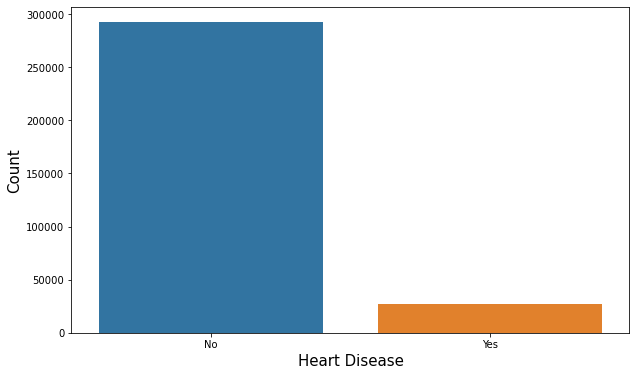

In [94]:
plt.figure(figsize=(10,6))
sns.countplot(x = df['HeartDisease'])
plt.xlabel('Heart Disease',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

We have an extremely unbalanced dataset, there are only less than 1% of the observations in our dataset have heart disease, due to the fact that we have a total 319794 data, we will use undersampling technique to crease a balanced dataset to train our model.

In [95]:
df['HeartDisease'] = df['HeartDisease'].map({'No':0,'Yes':1})

### Categorical Predictors

In [96]:
columns = ['Smoking', 'AlcoholDrinking', 'Stroke','DiffWalking', 'Sex', 'AgeCategory',
           'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']

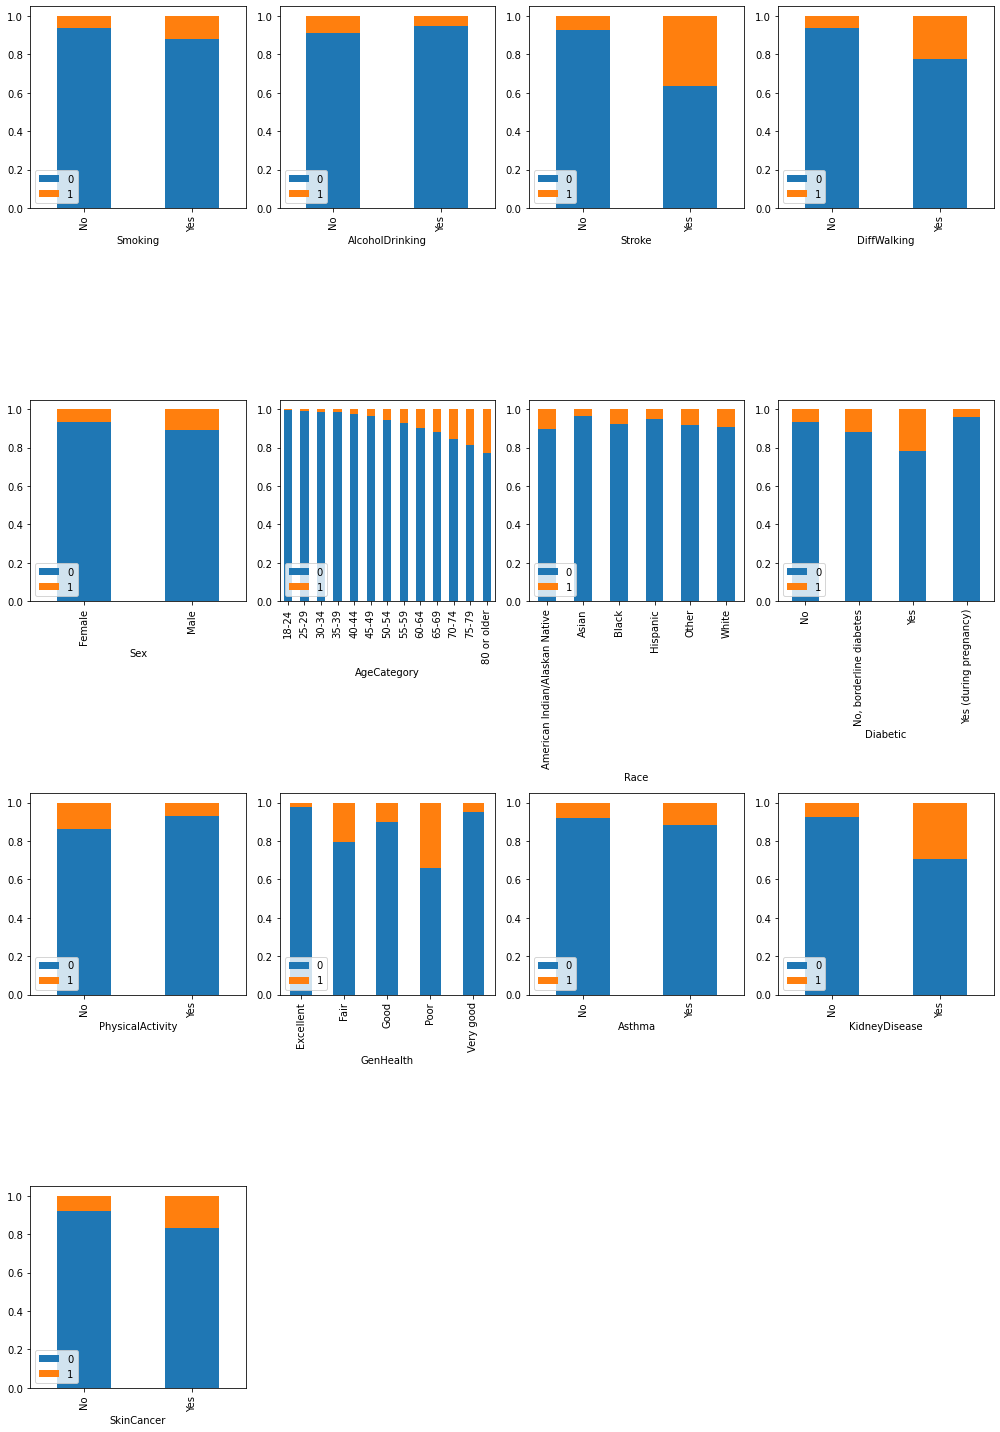

In [97]:
def stacked_barcharts(columns, ncols=4):
    nrows = 1 + (len(columns) - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, nrows * 5))
    for i, column in enumerate(columns):
        # calculate pivot table
        pivot = pd.crosstab(df['HeartDisease'], df[column])
        # divide by column sums to get frequency per column
        freq = pivot.div(pivot.sum())
        # display as stacked bar chart with 100%
        ax = axes[i // 4, i % 4] if nrows > 1 else axes[i]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            freq.transpose().plot(kind='bar', ax=ax, stacked=True, legend=False)
            ax.legend(loc = 'lower left')
    for i in range(len(columns), nrows * 4):
        ax = axes[i // 4, i % 4] if nrows > 1 else axes[i]
        fig.delaxes(ax)
    plt.tight_layout()

stacked_barcharts(columns)

From the bar plot above, we can see that for most of the categorical predictors, there's a clear difference of the fraction of people having heart disease within each catrgory respectively. For example, there seems to have a positive relationship between age and heart disease. And if the person has other disease, for instance stroke, or kidney disease, the possibility of having heart disease seems to be higher than healthy people.

### Numeric predictors

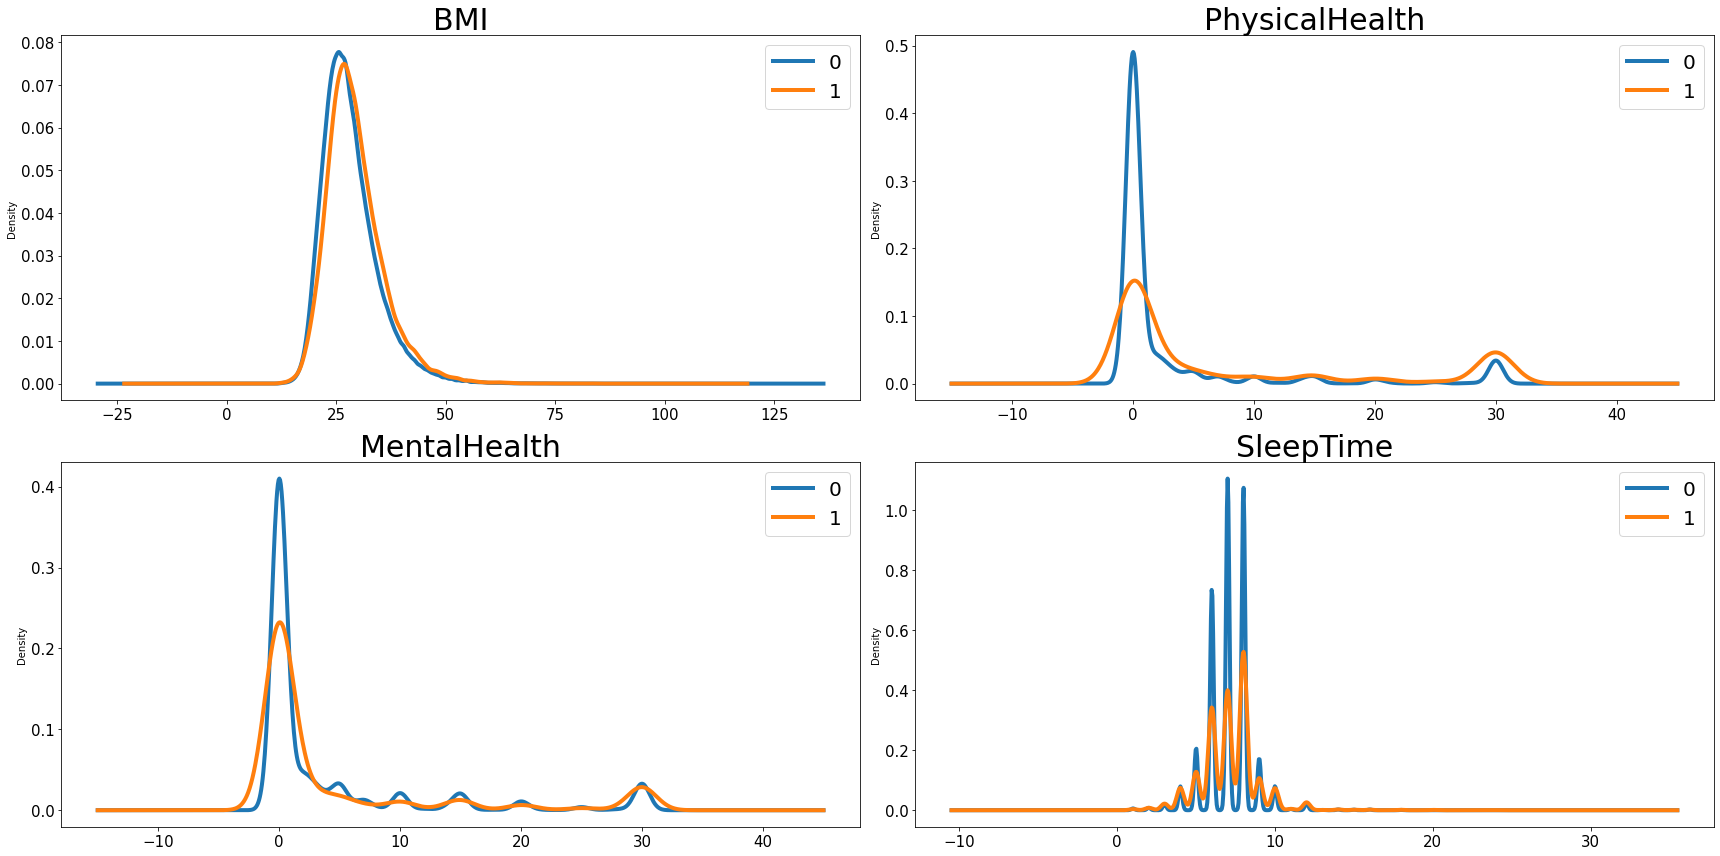

In [156]:
col3 = ['BMI','PhysicalHealth', 'MentalHealth','SleepTime']
ncols = 2
nrows = 1 + (len(col3) - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(24,12))
for i, column in enumerate(col3):    
    for response, group in df[['HeartDisease', column]].groupby('HeartDisease'):        
        group[column].plot.density(ax = axes[i//2,i%2],linewidth = 4,fontsize=15,label = response)#.set_xlim(min(df[column]),max(df[column]))
        axes[i//2,i%2].legend(loc = 'best',fontsize = 20)
    axes[i//2,i%2].set_title(column,size=30)    
plt.tight_layout()

For all the numeric variables, BMI seems to be a weak predictor since the distribution is almost identical regardless of whether the group of people have heart disease or not.

## 3. Data Preprocess

### Undersampling to construct balanced dataset

Due to the restrictions of our laptop's processing power, we only selected about 5000 records to train our models in this study. First, we randomly select 1% of the data from the group of people having heart disease, and using the undersampling technique to build a balanced dataset for the following study.

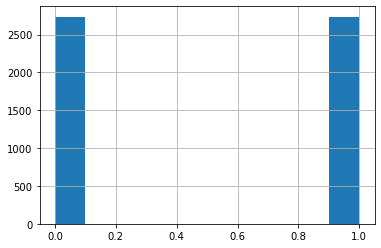

In [12]:
count0, count1 = df.HeartDisease.value_counts() 
hclass0 = df[df.HeartDisease == 0]
hclass1 = df[df.HeartDisease == 1].sample(frac=0.1,replace=False)
under0  = hclass0.sample(len(hclass1),replace=False)
heartus = pd.concat([under0,hclass1],axis=0)
# reshuffle the entire dataset
heartus = heartus.sample(frac=1,replace=False)
plt.hist(heartus.HeartDisease)
plt.grid()

### Create dummy variables for categorical variables

In [13]:
heartus = heartus.reset_index().copy()
# reset index after shuffle in the previous step
heartus.drop('index',axis=1,inplace=True)
# get dummy variables
heart = pd.get_dummies(heartus)
heart.head()

,HeartDisease,BMI,PhysicalHealth,MentalHealth,SleepTime,Smoking_No,Smoking_Yes,AlcoholDrinking_No,AlcoholDrinking_Yes,Stroke_No,...,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_No,Asthma_Yes,KidneyDisease_No,KidneyDisease_Yes,SkinCancer_No,SkinCancer_Yes
0,0,27.40,1.0,0.0,8.0,1,0,0,1,1,...,0,0,0,1,0,1,1,0,1,0
1,0,24.33,0.0,2.0,6.0,1,0,1,0,1,...,0,0,0,1,1,0,1,0,1,0
2,0,18.85,5.0,0.0,8.0,0,1,1,0,1,...,1,0,0,0,1,0,1,0,1,0
3,0,24.96,5.0,0.0,7.0,1,0,1,0,1,...,0,0,0,1,1,0,1,0,1,0
4,0,29.53,0.0,7.0,8.0,1,0,1,0,0,...,1,0,0,0,0,1,1,0,1,0


### Train-Test split

In [14]:
X = heart.iloc[:,1:].to_numpy()
y = heart.iloc[:,0].to_list()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25,random_state=42)

## 4. Classification Models

We built four classfication models to making predictions, the first three are Random Forest, Support Vector Classifier ,and Gradient Boosting. For Support Vector Classifier and Gradient Boosting, we used grid search to find the optimal hyperparameter, and for Random Forest, we used randomized search since the grid search was very slow. Finally, we bagged the three best models selected from the previous step and compared the results from model combination with the individual ones to see whether bagging can produce better results.

In [15]:
nmc      = 50
testSize = 0.25

### KNN Classifier

In [16]:
def knncls(X,y,nmc,testSize):
    fullModel = Pipeline([('scaler',MinMaxScaler()),
                          ('knn',KNeighborsClassifier(weights='distance'))])
    param_grid = {'knn__n_neighbors':np.arange(1,101)}
    shuffle_split = ShuffleSplit(test_size=testSize, n_splits=nmc)
    # set up search
    grid_search = GridSearchCV(fullModel,param_grid,cv=shuffle_split, return_train_score=True,n_jobs=-1)
    # implement search
    grid_search.fit(X,y)
    # move results into DataFrame
    results  = pd.DataFrame(grid_search.cv_results_)[['rank_test_score','mean_train_score','mean_test_score','param_knn__n_neighbors']]
    best_KNN = grid_search.best_estimator_
    return results,best_KNN   


In [17]:
# get best model
stime = time.time()
resultsKNN,best_KNN = knncls(X_train,y_train,nmc,testSize)
best_KNN.fit(X_train,y_train)
etime = time.time()
print(resultsKNN)
print("elapsed time:",etime-stime)

    rank_test_score  mean_train_score  mean_test_score param_knn__n_neighbors
0                99          0.999864         0.670127                      1
1               100          0.999864         0.670107                      2
2                98          0.999864         0.697605                      3
3                97          0.999864         0.698462                      4
4                96          0.999864         0.706407                      5
..              ...               ...              ...                    ...
95               38          0.999864         0.733866                     96
96               36          0.999864         0.733905                     97
97               33          0.999864         0.733963                     98
98               10          0.999864         0.734333                     99
99               24          0.999864         0.734099                    100

[100 rows x 4 columns]
elapsed time: 142.1403729915619


In [127]:
resultsKNN[resultsKNN['rank_test_score']==1]

,rank_test_score,mean_train_score,mean_test_score,param_knn__n_neighbors
83,1,0.999864,0.734761,84


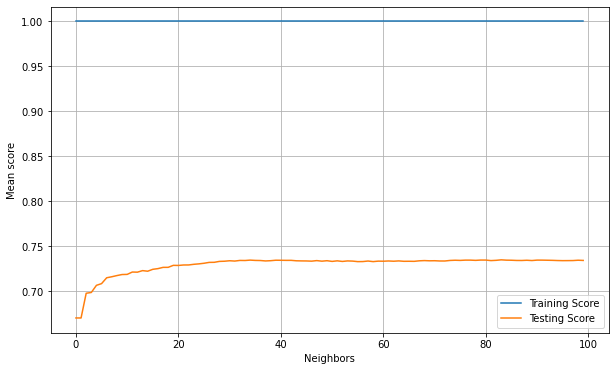

In [18]:
plt.figure(figsize=(10,6))
plt.plot(resultsKNN['mean_train_score'],label='Training Score')
plt.plot(resultsKNN['mean_test_score'],label='Testing Score')
plt.xlabel('Neighbors')
plt.ylabel('Mean score')
plt.legend()
plt.grid()
plt.show()

In [19]:
knn_r2 = best_KNN.score(X_test,y_test)
print('Testing R squared: ',knn_r2)

Testing R squared:  0.7421475529583638


In [20]:
print(best_KNN)
y_pred = best_KNN.predict(X_test)
cmat   = confusion_matrix(y_test, y_pred)
print(cmat)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('knn',
                 KNeighborsClassifier(n_neighbors=84, weights='distance'))])
[[501 151]
 [202 515]]


In [165]:
y_pred_prob_knn = best_KNN.predict_proba(X_test)[:,1]
fpr_knn, tpr_knn, thresholds_knn    = roc_curve(y_test,y_pred_prob_knn)

### SDGClassifier with log loss function

In [21]:
def SDGcls(X,y,alphalist,nmc,testSize):
    fullModel = Pipeline([('scaler',MinMaxScaler()),
                          ('sgd',SGDClassifier(loss="log",max_iter=1000, tol=1e-3,penalty='l2',
                                              validation_fraction=0.2,n_iter_no_change=10,early_stopping=True))])
    param_grid = {'sgd__alpha':alpha_list}
    shuffle_split = ShuffleSplit(test_size=testSize, n_splits=nmc)
    # set up search
    grid_search = GridSearchCV(fullModel,param_grid,cv=shuffle_split, return_train_score=True,n_jobs=-1)
    # implement search
    grid_search.fit(X,y)
    # move results into DataFrame
    results  = pd.DataFrame(grid_search.cv_results_)[['rank_test_score','mean_train_score','mean_test_score','param_sgd__alpha']]
    best_SDG = grid_search.best_estimator_
    return results,best_SDG 
      

In [22]:
#alpha_list = np.arange(0.01,1.05,0.05)
alpha_list = np.arange(0.0001,0.05,0.002)

# get best model
stime = time.time()
resultsSGD,best_SGD = SDGcls(X_train,y_train,alpha_list,nmc,testSize)
best_SGD.fit(X_train,y_train)
sgd_r2 = best_SGD.score(X_test,y_test)
etime = time.time()
print(resultsSGD)
print('Testing R squared: ',sgd_r2)
print("elapsed time:",etime-stime)

    rank_test_score  mean_train_score  mean_test_score param_sgd__alpha
0                25          0.704665         0.702181           0.0001
1                 2          0.762040         0.755190           0.0021
2                 1          0.760383         0.755424           0.0041
3                 4          0.759526         0.754041           0.0061
4                 3          0.758395         0.754333           0.0081
5                 5          0.756329         0.752814           0.0101
6                 6          0.756660         0.751899           0.0121
7                 8          0.755198         0.750574           0.0141
8                 7          0.755198         0.751120           0.0161
9                 9          0.753723         0.749893           0.0181
10               10          0.752567         0.749036           0.0201
11               11          0.752788         0.748393           0.0221
12               13          0.751384         0.748315          

In [23]:
print(best_SGD)
y_pred = best_SGD.predict(X_test)
cmat   = confusion_matrix(y_test, y_pred)
print(cmat)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.0041, early_stopping=True, loss='log',
                               n_iter_no_change=10, validation_fraction=0.2))])
[[522 130]
 [209 508]]


In [163]:
y_pred_prob_lr = best_SGD.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test,y_pred_prob_lr)

### Random Forest

In [24]:
def RandomForest(X,y,nmc,testSize):
    fullmodel = Pipeline(steps=[("scaler", MinMaxScaler()),
                                ("RF", RandomForestClassifier(random_state=42))
                               ])
    
    # use randomsearch to search the best parameters
    max_depth    = sp_randint(1, 11)
    max_features = sp_randint(1, 18)
    n_estimators = sp_randint(1,100)
    
    param_random = {'RF__max_depth':max_depth,'RF__max_features':max_features,'RF__n_estimators':n_estimators}
    shuffle      = ShuffleSplit(n_splits = nmc, test_size = testSize)

    # set the random search
    random_search = RandomizedSearchCV(fullmodel,param_random,cv=shuffle,return_train_score=True)

    # implement search
    random_search.fit(X,y)
    # move results into DataFrame
    results = pd.DataFrame(random_search.cv_results_)[['rank_test_score','mean_train_score','mean_test_score','param_RF__max_depth','param_RF__max_features','param_RF__n_estimators']]

    # set the best random forest model
    best_forest = random_search.best_estimator_
    return results,best_forest

# define the feature importance plot
def plot_feature_importances_heartus(model):
    n_features = X_train.shape[1]
    plt.barh(range(n_features), model.named_steps["RF"].feature_importances_, align='center')
    plt.yticks(np.arange(n_features), heart.columns.tolist()[1:])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)


   rank_test_score  mean_train_score  mean_test_score param_RF__max_depth  \
0                8          0.752982         0.730341                   6   
1                6          0.762833         0.732658                   6   
2                1          0.793119         0.740759                   8   
3                2          0.809903         0.740058                   9   
4                4          0.764282         0.734547                   6   
5               10          0.684542         0.680351                   1   
6                5          0.758441         0.733612                   6   
7                3          0.784795         0.739104                   8   
8                7          0.797336         0.732444                   8   
9                9          0.738915         0.721986                   5   

  param_RF__max_features param_RF__n_estimators  
0                      4                     96  
1                     10                     86  
2 

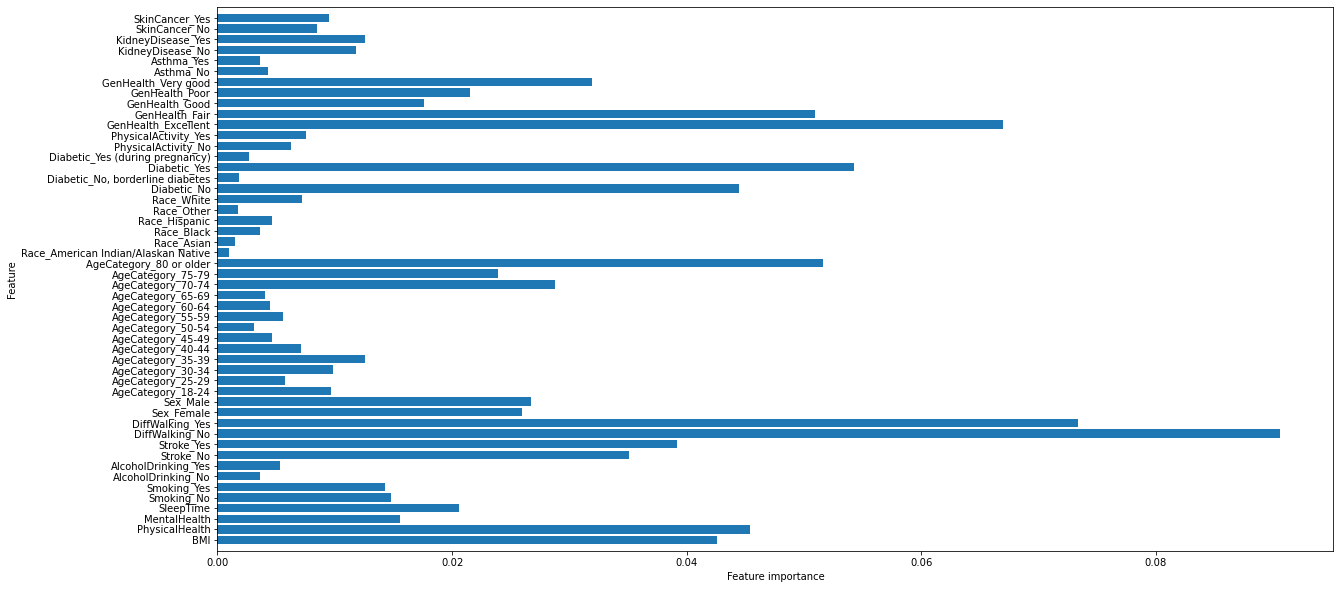

In [25]:
stime = time.time()
results,best_forest = RandomForest(X_train,y_train,nmc,testSize)
best_forest.fit(X_train,y_train)
etime = time.time()
print(results)
print("elapsed time:",etime-stime)

# draw the feature importance plot
plt.figure(figsize=(20,10))
plot_feature_importances_heartus(best_forest)

In [26]:
r2_RF = best_forest.score(X_test,y_test)
print('Testing Score: ',r2_RF)

Testing Score:  0.7538349159970782


In [27]:
print(best_forest)
y_pred = best_forest.predict(X_test)
cmat   = confusion_matrix(y_test, y_pred)
print(cmat)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('RF',
                 RandomForestClassifier(max_depth=8, max_features=7,
                                        n_estimators=79, random_state=42))])
[[503 149]
 [188 529]]


In [168]:
y_pred_prob_forest = best_forest.predict_proba(X_test)[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test,y_pred_prob_forest)

### Support Vector Machine

In [176]:
def svc(X,y,nmc,testSize):
    fullModel = Pipeline([("scaler", MinMaxScaler()),
                          ("nonlinsv", SVC(tol=0.001,random_state=42,probability=True))
                         ])

    # set up dictionary for grid search
    param_grid = {'nonlinsv__C':[0.25, 0.5, 0.75, 1.0, 1.5, 2.0],
                  'nonlinsv__gamma':[0.001,0.1,0.5,1.0,1.5,2.0],
                  'nonlinsv__kernel':['rbf']}
    # set up cross-validation shuffles
    shuffle_split = ShuffleSplit(test_size=testSize, n_splits=nmc)
    # set up search
    grid_search = GridSearchCV(fullModel,param_grid,cv=shuffle_split, return_train_score=True,n_jobs=-1)
    # implement search
    grid_search.fit(X,y)
    # move results into DataFrame
    results  = pd.DataFrame(grid_search.cv_results_)[['rank_test_score','mean_train_score','mean_test_score','param_nonlinsv__C','param_nonlinsv__gamma']]
    best_svc = grid_search.best_estimator_
    return results,best_svc


In [177]:
# get best model
stime = time.time()
results,best_SVC = svc(X_train,y_train,nmc,testSize)
best_SVC.fit(X_train,y_train)
etime  = time.time()
svc_r2 = best_SVC.score(X_test,y_test)
print(results)
print('Testing R squared: ',svc_r2)
print("elapsed time:",etime-stime)

    rank_test_score  mean_train_score  mean_test_score param_nonlinsv__C  \
0                29          0.654061         0.649971              0.25   
1                 4          0.775627         0.757605              0.25   
2                10          0.791228         0.741753              0.25   
3                30          0.719415         0.648179              0.25   
4                34          0.767687         0.628666              0.25   
5                36          0.893879         0.627868              0.25   
6                21          0.701455         0.697137               0.5   
7                 1          0.785432         0.759279               0.5   
8                 7          0.830832         0.747575               0.5   
9                22          0.861741         0.692405               0.5   
10               32          0.904035         0.635833               0.5   
11               35          0.921098         0.628023               0.5   
12          

In [178]:
print(best_SVC)
y_pred = best_SVC.predict(X_test)
cmat   = confusion_matrix(y_test, y_pred)
print(cmat)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('nonlinsv',
                 SVC(C=0.5, gamma=0.1, probability=True, random_state=42))])
[[487 165]
 [132 585]]


In [179]:
y_pred_prob_svc = best_SVC.predict_proba(X_test)[:,1]
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test,y_pred_prob_svc)

### Gradient Boosting

In [148]:
def gbc(X,y,nmc,testSize):
    # using pipeline to combine several steps 
    fullmodel = Pipeline([("scaler", MinMaxScaler()),
                          ("GBC", GradientBoostingClassifier(validation_fraction=0.2,n_iter_no_change=10,
                                                             tol=0.001,random_state=42))
                          ])
    # setting parameter to search
    param_grid = {'GBC__n_estimators':[100],'GBC__max_depth':[1,2,3],
                  'GBC__max_features':[5,10,15],
                  'GBC__learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
    
    shuffle = ShuffleSplit(n_splits = nmc, test_size = testSize)

    # set up grid search
    grid_search = GridSearchCV(fullmodel,param_grid,cv = shuffle,
                              return_train_score = True,n_jobs = -1)
    grid_search.fit(X,y)
    # store result to a dataframe
    result = pd.DataFrame(grid_search.cv_results_)[['rank_test_score','mean_train_score','mean_test_score','param_GBC__max_depth','param_GBC__max_features']]
    
    # store the best mddel
    best_model  = grid_search.best_estimator_ 
    return result,best_model


In [149]:
stime = time.time()
resultGBC,best_modelGBC = gbc(X_train,y_train,nmc,testSize)
best_modelGBC.fit(X_train,y_train)
r2 = best_modelGBC.score(X_test,y_test)
etime = time.time()
print(resultGBC)
print('R2: ',r2)
print("elapsed time:",etime-stime)

    rank_test_score  mean_train_score  mean_test_score param_GBC__max_depth  \
0                48          0.507115         0.505258                    1   
1                48          0.507115         0.505258                    1   
2                48          0.507115         0.505258                    1   
3                48          0.507115         0.505258                    2   
4                48          0.507115         0.505258                    2   
5                48          0.507115         0.505258                    2   
6                48          0.507115         0.505258                    3   
7                46          0.507167         0.505336                    3   
8                47          0.507128         0.505297                    3   
9                45          0.513392         0.512074                    1   
10               44          0.588882         0.583914                    1   
11               43          0.634301         0.6355

In [150]:
print(best_modelGBC)
y_pred = best_modelGBC.predict(X_test)
cmat   = confusion_matrix(y_test, y_pred)
print(cmat)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('GBC',
                 GradientBoostingClassifier(max_features=10,
                                            n_iter_no_change=10,
                                            random_state=42, tol=0.001,
                                            validation_fraction=0.2))])
[[510 142]
 [157 560]]


In [181]:
y_pred_prob_gb = best_SVC.predict_proba(X_test)[:,1]
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test,y_pred_prob_gb)

### Model Combination with Voting

In [230]:
def voting(X1,y1,X2,y2,model1,model2): 
    # Using Pipeline to combine MinMax Scalar and hard voting combination
    fullmodel = Pipeline([("scaler", MinMaxScaler()),
                          ('vote', VotingClassifier([('model1', model1[1]),
                                                     ('model2', model2[1])], voting='soft'))
                         ])

    fullmodel.fit(X1, y1)
    accuracy = fullmodel.score(X2,y2)
    return accuracy
accuracy1 = voting(X_train,y_train,X_test,y_test,best_modelGBC,best_KNN)
accuracy2 = voting(X_train,y_train,X_test,y_test,best_modelGBC,best_SGD)
accuracy3 = voting(X_train,y_train,X_test,y_test,best_modelGBC,best_forest)

print('Accuracy: ',accuracy1)
print('Accuracy: ',accuracy2)
print('Accuracy: ',accuracy3)

Accuracy:  0.7706355003652301
Accuracy:  0.7772096420745069
Accuracy:  0.7764791818845873


In [229]:
def voting(X1,y1,X2,y2,model1,model2,model3): 
    # Using Pipeline to combine MinMax Scalar and hard voting combination
    fullmodel = Pipeline([("scaler", MinMaxScaler()),
                          ('vote', VotingClassifier([('model1', model1[1]),
                                                     ('model2', model2[1]),
                                                     ('model3', model3[1])], voting='soft'))
                         ])

    fullmodel.fit(X1, y1)
    accuracy = fullmodel.score(X2,y2)
    return accuracy
accuracy1 = voting(X_train,y_train,X_test,y_test,best_modelGBC,best_KNN,best_SGD)
accuracy2 = voting(X_train,y_train,X_test,y_test,best_modelGBC,best_KNN,best_forest)
accuracy3 = voting(X_train,y_train,X_test,y_test,best_modelGBC,best_SGD,best_forest)

print('Accuracy: ',accuracy1)
print('Accuracy: ',accuracy2)
print('Accuracy: ',accuracy3)

Accuracy:  0.7779401022644266
Accuracy:  0.775018261504748
Accuracy:  0.7859751643535428


### Super Test

In [213]:
c0, c1 = df.HeartDisease.value_counts() 
h0     = df[df.HeartDisease == 0]
h1     = df[df.HeartDisease == 1].sample(frac=0.3,replace=False)
u0     = h0.sample(len(h1),replace=False)
supertest = pd.concat([u0,h1],axis=0)
supertest = heartus.reset_index().copy()
# reset index after shuffle in the previous step
supertest.drop('index',axis=1,inplace=True)
# get dummy variables
supertest = pd.get_dummies(supertest)
X_final   = supertest.iloc[:,1:].to_numpy()
y_final   = supertest.iloc[:,0].to_list()

In [242]:
bestmodel = Pipeline([("scaler", MinMaxScaler()),
                      ('vote', VotingClassifier([('model1', best_modelGBC[1]),
                                                 ('model2', best_SGD[1]),
                                                 ('model3', best_forest[1])], voting='soft'))
                     ])
bestmodel.fit(X,y)
best_SVC.fit(X,y)
print('Model Combo',bestmodel.score(X_final,y_final))
print('SVM',best_SVC.score(X_final,y_final))

Model Combo 0.7820606503470954
SVM 0.7824260138838144


In [244]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True) 

Model Combo AUC:  0.861362826015539
SVC AUC:  0.8616303410055227


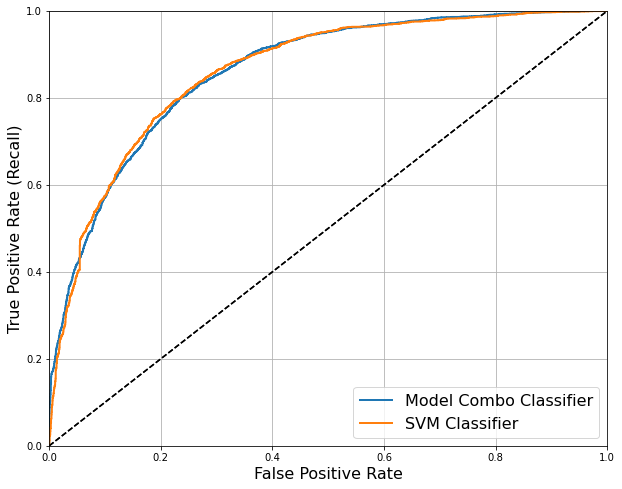

In [243]:
y_pred_prob_combo = bestmodel.predict_proba(X_final)[:,1]
y_pred_prob_SVC   = best_SVC.predict_proba(X_final)[:,1]

fpr_combo, tpr_combo, thresholds_combo = roc_curve(y_final,y_pred_prob_combo)
fpr_SVC, tpr_SVC, thresholds_SVC = roc_curve(y_final,y_pred_prob_SVC)
print('Model Combo AUC: ', roc_auc_score(y_final, y_pred_prob_combo))
print('SVC AUC: ', roc_auc_score(y_final, y_pred_prob_SVC))


plt.figure(figsize=(10, 8))
plot_roc_curve(fpr_combo, tpr_combo, "Model Combo Classifier")
plot_roc_curve(fpr_SVC, tpr_SVC, "SVM Classifier")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()